In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels
import seaborn as sns
import numpy as np
import scipy.stats as sps

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.decomposition import PCA
sns.set(style='ticks')

In [2]:
%matplotlib inline

# Задание 1

Скачаем данные котировок акций
https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=GOOGL&outputsize=full&datatype=csv&apikey=your_key

https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=APPLE&outputsize=full&datatype=csv&apikey=your_key

https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=FB&outputsize=full&datatype=csv&apikey=your_key

In [3]:
google = pd.read_csv("daily_GOOGL.csv")
apple  = pd.read_csv("daily_AAPL.csv")
fb = pd.read_csv("daily_FB.csv")

In [4]:
google.head()

,timestamp,open,high,low,close,volume
0,2020-05-29,1420.43,1436.73,1415.98,1433.52,1822082
1,2020-05-28,1400.00,1444.46,1399.08,1418.24,1759787
2,2020-05-27,1420.00,1425.35,1394.60,1420.28,1584185
3,2020-05-26,1441.96,1445.11,1419.39,1421.37,2229488
4,2020-05-22,1403.90,1417.00,1395.95,1413.24,1427206


In [5]:
# Facebook вышел на IPO в 2012 году, поэтому ограничимся последними 8 годами
ipo_fb = fb["timestamp"][fb.shape[0]-1]
google = google[google["timestamp"] >= ipo_fb]
apple = apple[apple["timestamp"] >= ipo_fb]
fb = fb[fb["timestamp"] >= ipo_fb]

# Задание 2

In [6]:
daily_return = lambda x: (x[-2::-1] - x[:0:-1])/x[:0:-1] 

In [7]:
ggl_dl = daily_return(np.array(google["close"]))
app_dl = daily_return(np.array(apple["close"]))
fb_dl = daily_return(np.array(fb["close"]))

In [8]:
time = np.array(fb["timestamp"])[:0:-1]
daily_returns = pd.DataFrame({"google": ggl_dl, "apple": app_dl, "fb": fb_dl})

In [9]:
daily_returns.head()

,google,apple,fb
0,0.022835,0.058260,-0.109903
1,-0.021674,-0.007679,-0.089039
2,0.014414,0.024400,0.032258
3,-0.009517,-0.009184,0.032188
4,-0.020094,-0.005360,-0.033909


В среднем акции компаний растут

In [10]:
print(f"Среднее, медиана и дисперсия daily_returns для компании google {ggl_dl.mean()},\
 {np.median(ggl_dl)}, {ggl_dl.var()}")

Среднее, медиана и дисперсия daily_returns для компании google 0.0006493424225466771, 0.0006759168949990421, 0.0003722297925394275


Теперь попробуем оценить распределение наших данных. Для начала, для наглядности, произведем ядерную оценку плотности.

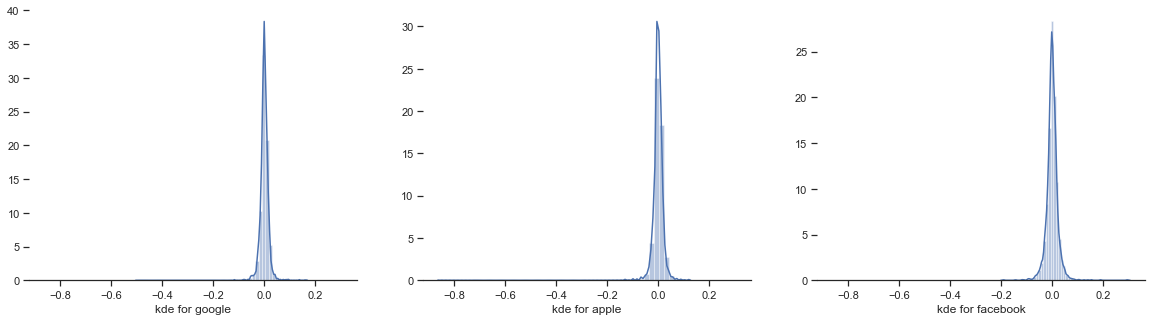

In [48]:
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True)
sns.despine(left=True)
sns.distplot(ggl_dl, ax=axes[0], axlabel="kde for google")

sns.distplot(app_dl, ax=axes[1], axlabel="kde for apple")
sns.distplot(fb_dl, ax=axes[2], axlabel="kde for facebook")

Не похоже, что наши данные из нормального распредиления со среднем в 0,  тк хвосты "тяжелые", возможно это распределение стьюдента. Построим qq-plot для нормального распределения и распределения Стьюдента.

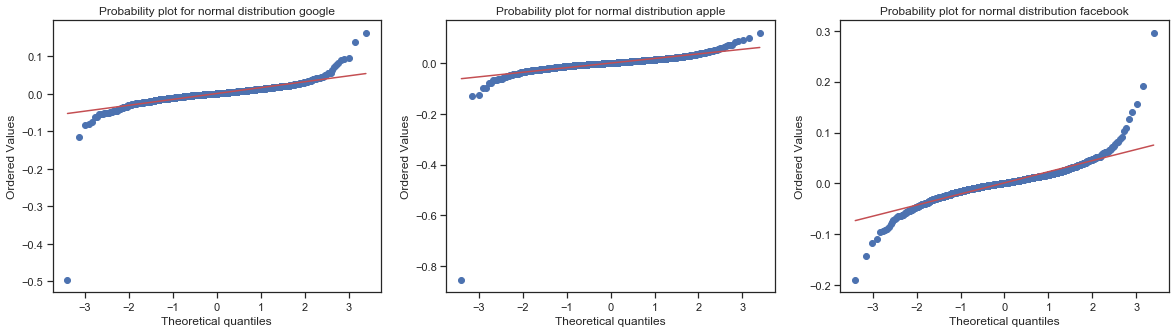

In [12]:
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True,)
sps.probplot(ggl_dl, plot=axes[0])
axes[0].set_title("Probability plot for normal distribution google")
sps.probplot(app_dl, plot=axes[1])
axes[1].set_title("Probability plot for normal distribution apple")
sps.probplot(fb_dl, plot=axes[2])
axes[2].set_title("Probability plot for normal distribution facebook")
plt.show()

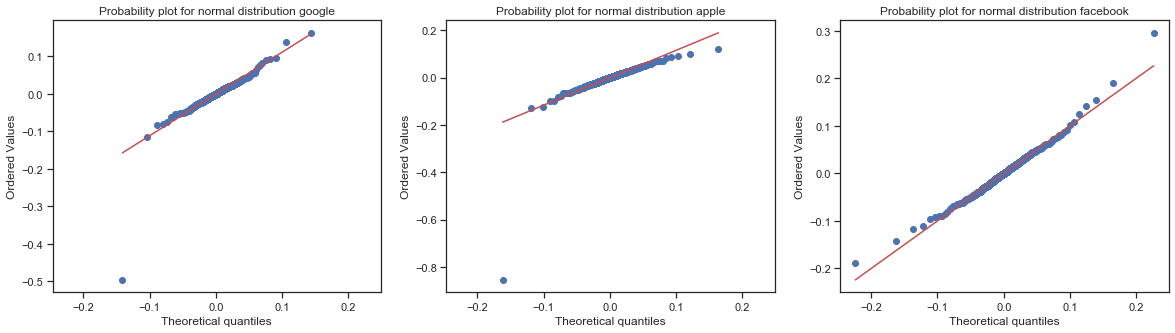

In [13]:
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True,)
sps.probplot(ggl_dl, plot=axes[0], dist=sps.t, sparams=sps.t.fit(ggl_dl))
axes[0].set_title("Probability plot for normal distribution google")
sps.probplot(app_dl, plot=axes[1], dist=sps.t, sparams=sps.t.fit(app_dl))
axes[1].set_title("Probability plot for normal distribution apple")
sps.probplot(fb_dl, plot=axes[2], dist=sps.t, sparams=sps.t.fit(fb_dl))
axes[2].set_title("Probability plot for normal distribution facebook")
plt.show()

Уже по qq-plot видно, что данные не из нормального распределения, однако убедимся в этом при помощи критериев Шапиро-Уилка, Колмогорова и Жарка-Бера.

In [14]:
pvalues = [sps.kstest(ggl_dl, sps.norm(*sps.norm.fit(ggl_dl)).cdf)[1],
           sps.shapiro(ggl_dl)[1],
           sps.jarque_bera(ggl_dl)[1]]

print("p-values for google:", pvalues)

p-values for google: [3.700661929030257e-26, 0.0, 0.0]


In [15]:
# Для чистоты проведем множественною проверку гипотез
multipletests(pvalues)

(array([ True,  True,  True]),
 array([0., 0., 0.]),
 0.016952427508441503,
 0.016666666666666666)

In [16]:
pvalues = [sps.kstest(app_dl, sps.norm(*sps.norm.fit(app_dl)).cdf)[1],
           sps.shapiro(app_dl)[1],
           sps.jarque_bera(app_dl)[1]]

print("p-values for apple:", pvalues)

p-values for apple: [1.505023406074506e-46, 0.0, 0.0]


In [17]:
# Для чистоты проведем множественною проверку гипотез
multipletests(pvalues)

(array([ True,  True,  True]),
 array([0., 0., 0.]),
 0.016952427508441503,
 0.016666666666666666)

In [18]:
pvalues = [sps.kstest(fb_dl, sps.norm(*sps.norm.fit(fb_dl)).cdf)[1],
           sps.shapiro(fb_dl)[1],
           sps.jarque_bera(fb_dl)[1]]

print("p-values for facebook:", pvalues)

p-values for facebook: [1.7739096031964716e-15, 2.4725566683589173e-38, 0.0]


In [19]:
# Для чистоты проведем множественною проверку гипотез
multipletests(pvalues)

(array([ True,  True,  True]),
 array([1.77635684e-15, 0.00000000e+00, 0.00000000e+00]),
 0.016952427508441503,
 0.016666666666666666)

Нормальность отвергается. Для проверки принадлежности к распределению Стьюдента воспользуемся критерием Колмогорова

In [20]:
print("p-value for google:", sps.kstest(ggl_dl, sps.t(*sps.t.fit(ggl_dl)).cdf)[1])

p-value for google: 0.7633948131964531


In [21]:
print("p-value for google:", sps.kstest(app_dl, sps.t(*sps.t.fit(app_dl)).cdf)[1])

p-value for google: 0.7086842385745717


In [22]:
print("p-value for google:", sps.kstest(fb_dl, sps.t(*sps.t.fit(fb_dl)).cdf)[1])

p-value for google: 0.7676391723641243


Все p-value>0.05, поэтому мы принимаем гипотезу о том, что наши данные из распределения Стьюдента

Далле проверим стационарность по времени, для этого для начала визуализируем наши daily returns

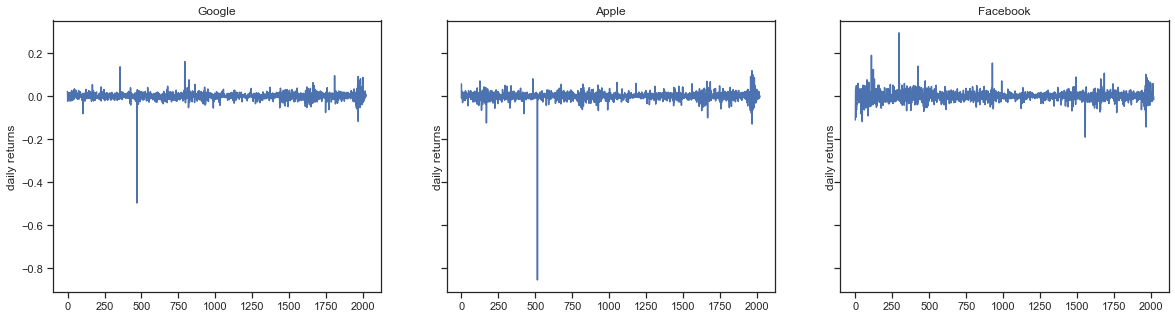

In [23]:
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)
time = np.arange(ggl_dl.shape[0])
plt.plot()
axes[0].plot(time, ggl_dl)
axes[0].set_title("Google")
axes[0].set_ylabel("daily returns")
axes[1].plot(time, app_dl)
axes[1].set_title("Apple")
axes[1].set_ylabel("daily returns")
axes[2].plot(time, fb_dl)
axes[2].set_title("Facebook")
axes[2].set_ylabel("daily returns")
plt.show()

На первый взгляд не видно никаких трендов и сезонностей, однако применим критерий Дики-Фуллера, чтобы убедиться в этом

In [24]:
print("Dickey-Fuller test: p =", adfuller(ggl_dl)[1])

Dickey-Fuller test: p = 1.7127697613245807e-27


In [25]:
print("Dickey-Fuller test: p =", adfuller(app_dl)[1])

Dickey-Fuller test: p = 0.0


In [26]:
print("Dickey-Fuller test: p =", adfuller(fb_dl)[1])

Dickey-Fuller test: p = 6.702668392792895e-28


На основе критерия можем сделать вывод что наши наблюдения стационарны по времени, возможно мы избались от линейного треда, если он был при помощи Дифференцирования $p_{i+1}-p_{i}$ 

Проверим наличие временной зависимости, при помощи автокорреляционной функции

На уровне значимости 0.05 у компании google наблюдается небольшая корреляция для каждого 7 дня. Корреляции у остальных компаний не стат значимы.

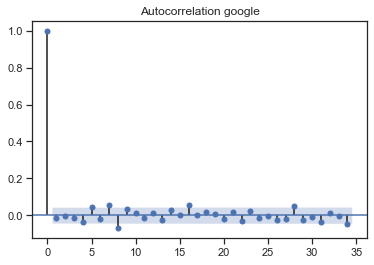

In [27]:
plot_acf(ggl_dl,  title='Autocorrelation google')
plt.show()

In [28]:
corr = np.abs(acf(ggl_dl))[1:]
print(f"Максимальный размер корреляции {corr.max()}, наблюдается в {corr.argmax()} дне")

Максимальный размер корреляции 0.0718923847610279, наблюдается в 7 дне


C:\Users\miair\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


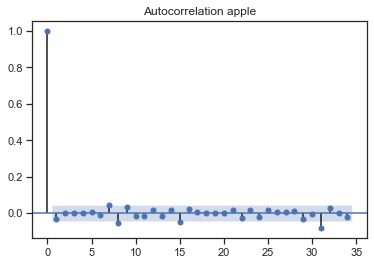

In [29]:
plot_acf(app_dl, title='Autocorrelation apple')
plt.show()

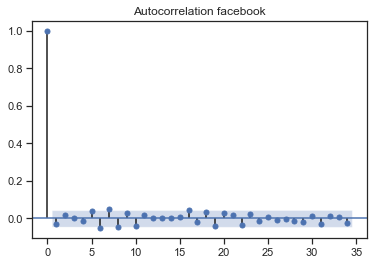

In [30]:
plot_acf(fb_dl, title='Autocorrelation facebook')
plt.show()

Теперь попробуем найти взаимосвязи между разными акциями, для начала посчитаем корреляцию.

In [31]:
daily_returns.corr()

,google,apple,fb
google,1.000000,0.285537,0.425148
apple,0.285537,1.000000,0.245363
fb,0.425148,0.245363,1.000000


Присутсует корреляция между акциями всех компаний, особенно большая между компаниями google и facebook

Также давайте проведем Тест Грэнджера, возможно он поможет найти какие-то более явные зависимости.

In [32]:
def granger_matrix(X, maxlag):
    min_p_values = pd.DataFrame(np.zeros((X.shape[1], X.shape[1])), index=X.columns, columns=X.columns)
    
    for column1 in X.columns:
        for column2 in X.columns:
            test = grangercausalitytests(np.asarray(daily_returns[[column1, column2]]), maxlag=maxlag, verbose=False)
            p_value = min([test[key][0]["ssr_ftest"][1] for key in test])
            min_p_values[column1][column2] = p_value
    return min_p_values

In [33]:
# Минимальные p-value
granger_matrix(daily_returns, 10)

,google,apple,fb
google,1.000000,0.012753,0.000566
apple,0.028332,1.000000,0.000208
fb,0.292117,0.228226,1.000000


Для пары google facebook и facebook apple  p-value > 0.05, поэтому нулевая гипотеза о равенстве коэффициентов в регрессии отвергается, значит присутствует некая линейная зависимость

In [34]:
grangercausalitytests(np.asarray(daily_returns[["google", "fb"]]), maxlag=10, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1104  , p=0.2921  , df_denom=2015, df_num=1
ssr based chi2 test:   chi2=1.1121  , p=0.2916  , df=1
likelihood ratio test: chi2=1.1118  , p=0.2917  , df=1
parameter F test:         F=1.1104  , p=0.2921  , df_denom=2015, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8375  , p=0.4329  , df_denom=2012, df_num=2
ssr based chi2 test:   chi2=1.6792  , p=0.4319  , df=2
likelihood ratio test: chi2=1.6785  , p=0.4320  , df=2
parameter F test:         F=0.8375  , p=0.4329  , df_denom=2012, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5714  , p=0.6339  , df_denom=2009, df_num=3
ssr based chi2 test:   chi2=1.7200  , p=0.6325  , df=3
likelihood ratio test: chi2=1.7193  , p=0.6327  , df=3
parameter F test:         F=0.5714  , p=0.6339  , df_denom=2009, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4366  , p=0.

{1: ({'ssr_ftest': (1.110420509803891, 0.2921168962904286, 2015.0, 1),
   'ssr_chi2test': (1.1120737413321349, 0.29163160708199143, 1),
   'lrtest': (1.1117674346296553, 0.2916980699678047, 1),
   'params_ftest': (1.1104205098036584, 0.2921168962904474, 2015.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.8375324288820178, 0.4329279405808205, 2012.0, 2),
   'ssr_chi2test': (1.6792275437922766, 0.4318772943696999, 2),
   'lrtest': (1.6785289218150865, 0.432028180205854, 2),
   'params_ftest': (0.8375324288822519, 0.43292794058072337, 2012.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.5713512281088425, 0.6338813749483361, 2009.0, 3),
   'ssr_chi2test': (1.72002599681547, 0.6324907744917689, 3),
   'lrtest': (1.7192926615625765, 0.6326531477699617, 3),
   'params_ftest': (0.5713512281089652, 0.6338813749482369, 2009.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 

Также давайте воспользуемся PCA, для дополнительной анализа и визуализации данных.

Применим PCA к нашим данным после чего, построим вектора каждой компании в пространстве первой и второй компоненты

In [35]:
# normalised time-series as an input for PCA
m = daily_returns.mean(axis=0)
s = daily_returns.std(ddof=1, axis=0)
pca_dt = (daily_returns - m)/s

In [36]:
pca = PCA(n_components=2)
pca.fit(pca_dt)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [37]:
V = np.array([pca.components_[:,0], pca.components_[:,1], pca.components_[:,2]])

In [38]:
pca.components_

array([[-0.62016422, -0.50389986, -0.60123313],
       [ 0.27257296, -0.85707927,  0.43717172]])

In [39]:
after_pca = pca.transform(pca_dt)

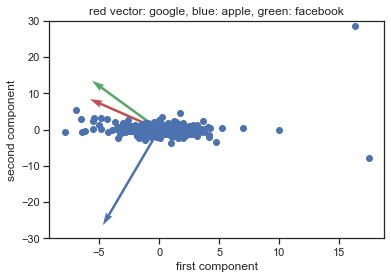

In [40]:
origin = [0], [0] # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=3, label="green")
plt.scatter(after_pca[:, 0], after_pca[:, 1])
plt.title("red vector: google, blue: apple, green: facebook")
plt.xlabel("first component")
plt.ylabel("second component")
plt.ylim(-30,30)
plt.show()

Как можно заметить из графика представленного выше, акции Apple описывают большую часть дисперсии выборки. А вектора apple и facebook практически коллинеарны, что может свидетельствовать о наличии линейной зависимости

# Задание №3

In [41]:
# Сгенерируем выборку из нормального распределения по три реализации для каждой акции
norm = sps.norm()
num_samples = 3
f_google = norm.rvs(size=(num_samples, daily_returns.shape[0]))
f_apple = norm.rvs(size=(num_samples, daily_returns.shape[0]))
f_facebook = norm.rvs(size=(num_samples, daily_returns.shape[0]))

Profit-and-loss колеблется около нуля проседая в очевидных выбросах

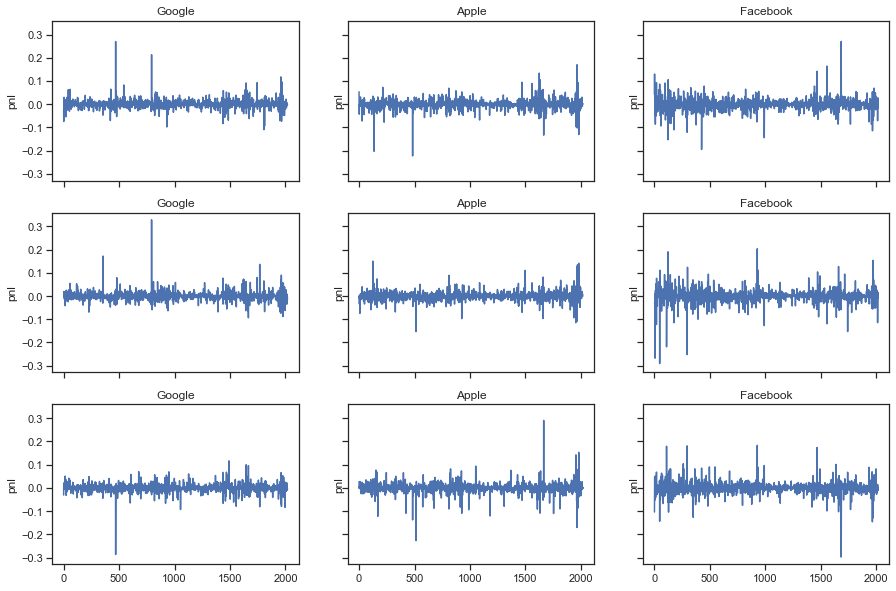

In [42]:
# визуализируем pnl
f, axes = plt.subplots(num_samples, 3, figsize=(15, 10), sharex=True, sharey=True)
for i in range(num_samples):   
    time = np.arange(ggl_dl.shape[0])
    pnl = f_google[i]*np.array(daily_returns["google"])
    axes[i][0].plot(time, pnl)
    axes[i][0].set_title("Google")
    axes[i][0].set_ylabel("pnl")
    pnl = f_apple[i]*np.array(daily_returns["apple"])
    axes[i][1].plot(time, pnl)
    axes[i][1].set_title("Apple")
    axes[i][1].set_ylabel("pnl")
    pnl = f_facebook[i]*np.array(daily_returns["fb"])
    axes[i][2].plot(time, pnl)
    axes[i][2].set_title("Facebook")
    axes[i][2].set_ylabel("pnl")


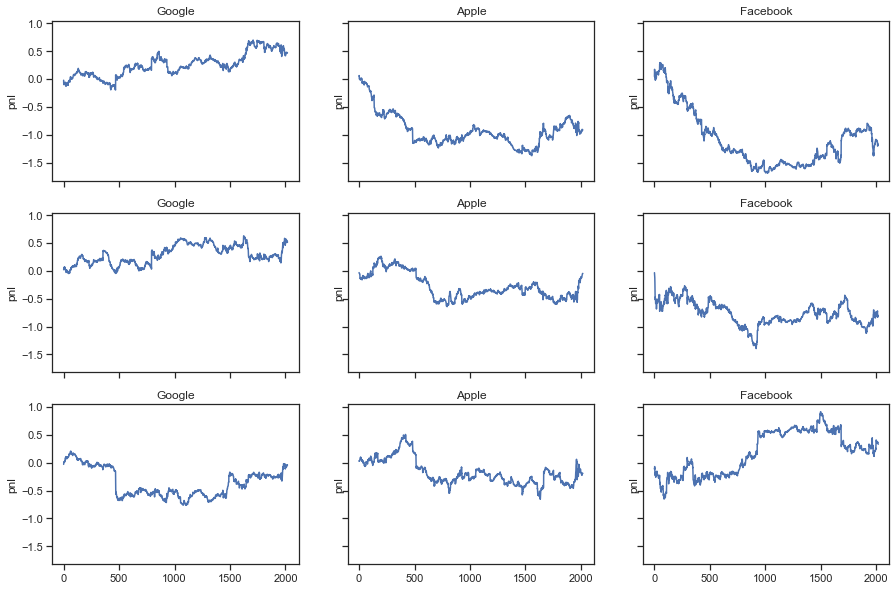

In [43]:
# визуализируем cumsum(pnl)
f, axes = plt.subplots(num_samples, 3, figsize=(15, 10), sharex=True, sharey=True)
for i in range(num_samples):   
    time = np.arange(ggl_dl.shape[0])
    pnl = f_google[i]*np.array(daily_returns["google"])
    axes[i][0].plot(time, np.cumsum(pnl))
    axes[i][0].set_title("Google")
    axes[i][0].set_ylabel("pnl")
    pnl = f_apple[i]*np.array(daily_returns["apple"])
    axes[i][1].plot(time, np.cumsum(pnl))
    axes[i][1].set_title("Apple")
    axes[i][1].set_ylabel("pnl")
    pnl = f_facebook[i]*np.array(daily_returns["fb"])
    axes[i][2].plot(time, np.cumsum(pnl))
    axes[i][2].set_title("Facebook")
    axes[i][2].set_ylabel("pnl")

# Задание 4

In [44]:
hit_rate = lambda x, y: (np.sign(x) == np.sign(y)).mean()
SR = lambda pnl: pnl.mean()/pnl.std()

In [45]:
# Сгенерируем 100 реализаций нашей выборки
norm = sps.norm()
num_samples = 100
f_google = norm.rvs(size=(num_samples, daily_returns.shape[0]))
f_apple = norm.rvs(size=(num_samples, daily_returns.shape[0]))
f_facebook = norm.rvs(size=(num_samples, daily_returns.shape[0]))

In [46]:
hit_rate_ = [[], [], []]
SR_ = [[], [], []]
for i in range(num_samples):
    hit_rate_[0].append(hit_rate(f_google[i], daily_returns["google"]))
    hit_rate_[1].append(hit_rate(f_apple[i], daily_returns["apple"]))
    hit_rate_[2].append(hit_rate(f_facebook[i], daily_returns["fb"]))
    SR_[0].append(SR(f_google[i]*daily_returns["google"]))
    SR_[1].append(SR(f_apple[i]*daily_returns["apple"]))
    SR_[2].append(SR(f_facebook[i]*daily_returns["fb"]))

Как и следовало ожидать чем выше показатель эффективность инвестиционного портфеля(Sharpe Ratio), тем выше hit rate

Text(0.5, 0, 'hit rate')

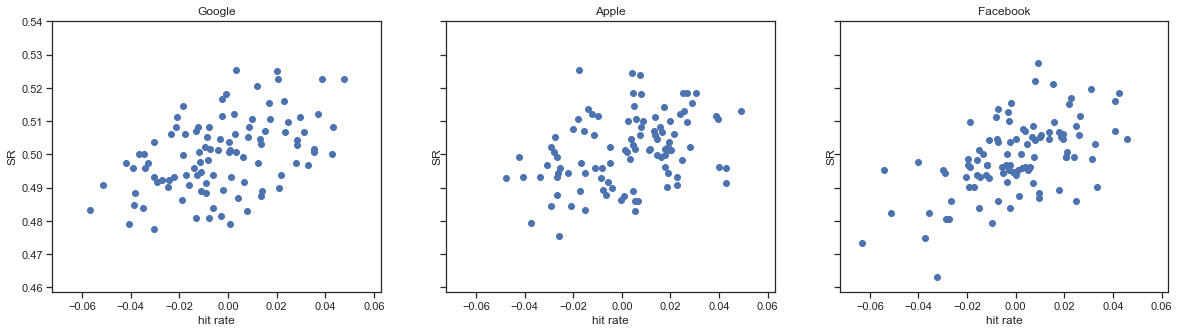

In [47]:
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)
axes[0].scatter(SR_[0], hit_rate_[0])
axes[0].set_title("Google")
axes[0].set_ylabel("SR")
axes[0].set_xlabel("hit rate")
axes[1].scatter(SR_[1], hit_rate_[1])
axes[1].set_title("Apple")
axes[1].set_ylabel("SR")
axes[1].set_xlabel("hit rate")
axes[2].scatter(SR_[2], hit_rate_[2])
axes[2].set_title("Facebook")
axes[2].set_ylabel("SR")
axes[2].set_xlabel("hit rate")